In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('../Data/all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
# df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'] = df['sentiment'].map({'positive': 2, 'negative': 0, 'neutral': 1})
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [5]:
sentiment = df.iloc[:,0]
headline = df.iloc[:,1]

sentiment.value_counts()

sentiment
1    2879
2    1363
0     604
Name: count, dtype: int64

In [6]:
from sklearn.utils import resample, shuffle

neutral = df[df.sentiment == 1]
positive = df[df.sentiment == 2]
negative = df[df.sentiment == 0]

# neutral = resample(neutral,
#                                 replace = False, # sample without replacement
#                                 n_samples = len(positive), # match minority n
#                                 random_state = 27) # reproducible results

positive_upsampled = resample(positive,
                            replace=True, # sample with replacement
                            n_samples=len(neutral), # match number in majority class
                            random_state=27) # reproducible results

negative_upsampled = resample(negative,
                            replace=True, # sample with replacement
                            n_samples=len(neutral), # match number in majority class
                            random_state=27) # reproducible results

df_upsampled = pd.concat([neutral, positive_upsampled, negative_upsampled])

df_upsampled = shuffle(df_upsampled)

df_upsampled.reset_index(drop=True, inplace=True)

df_upsampled.sentiment.value_counts()

sentiment
1    2879
0    2879
2    2879
Name: count, dtype: int64

In [7]:
sentiment = df_upsampled.iloc[:,0]
headline = df_upsampled.iloc[:,1]

In [8]:
num_classes = df['sentiment'].nunique()
print("Class count:", num_classes)
total_samples = len(df)

class_weights = []
for i in range(num_classes):
    class_weights.append(total_samples/(num_classes*np.sum(sentiment==i)))
class_weights = np.array(class_weights)
print("Class weights:", class_weights)


Class count: 3
Class weights: [0.56107445 0.56107445 0.56107445]


In [9]:
import torch
import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, headline), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
# print(vocab.get_stoi())
# torch.save(vocab, 'vocab.pt')
print(tokenizer('Hello world'))
vocab(['Hello', 'world'])

['hello', 'world']


[0, 339]

In [17]:
vocab.get_stoi().values()

dict_values([315, 1888, 7036, 1, 1847, 3248, 5264, 848, 6104, 2113, 273, 1645, 2980, 6193, 482, 5434, 2183, 6147, 1891, 0, 2675, 668, 369, 6868, 41, 9491, 73, 3174, 20, 2549, 198, 7561, 4969, 3327, 401, 622, 3032, 9045, 1900, 6, 99, 10355, 4937, 154, 223, 244, 3783, 991, 7984, 7323, 1516, 7218, 7383, 26, 486, 8264, 2792, 15, 4256, 1288, 7991, 3943, 3494, 2198, 1098, 2858, 356, 1395, 259, 4011, 2, 7745, 143, 3, 1917, 2547, 2023, 3321, 4450, 3109, 6124, 42, 9162, 470, 7756, 5387, 7962, 4, 3635, 1971, 872, 7, 9081, 1099, 407, 874, 3425, 484, 180, 5, 3935, 1958, 6786, 3992, 334, 6068, 8040, 57, 475, 1432, 6375, 3827, 7232, 1628, 10404, 8, 333, 7933, 40, 1379, 3728, 159, 3105, 939, 10317, 836, 6693, 3932, 6811, 6815, 9666, 501, 9, 8045, 3755, 3533, 5379, 934, 52, 9935, 9611, 454, 1503, 6246, 2810, 135, 1794, 9004, 3175, 7014, 8871, 18, 1276, 3436, 10309, 9629, 2504, 3191, 10, 4530, 466, 131, 2926, 536, 5993, 3590, 290, 11, 8631, 736, 566, 1635, 4632, 8318, 12, 1769, 5961, 2812, 547, 4214, 1

In [14]:
vocab_size = len(vocab)
vocab_size

10444

In [51]:
class HeadlineDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text)
        indices = [self.vocab[token] for token in tokens]
        x_tensor = torch.tensor(indices, dtype=torch.long)
        y_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        return x_tensor, y_tensor

In [52]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab['<unk>'])
    # texts_padded = pack_padded_sequence
    labels_tensor = torch.stack(labels)
    return texts_padded, labels_tensor

In [53]:
X = headline
y = sentiment
dataset = HeadlineDataset(X, y, vocab, tokenizer)

train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(12))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

In [54]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        # self.bn = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        # out = self.fc(out)
        return out


In [55]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha[target] * (1-pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [56]:

embedding_dim = 100
hidden_dim = 128
num_layers = 2
num_classes = 3

torch.manual_seed(12)
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, num_classes).to(device)
model(train_dataset[0][0].unsqueeze(0).to(device))

tensor([[-0.0311,  0.0126,  0.2323]], grad_fn=<AddmmBackward0>)

In [57]:
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=torch.tensor(class_weights).to(device), gamma=2, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)


In [58]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_preds = []

    with torch.inference_mode():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y.long())

            running_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            y_true += y.tolist()
            y_preds += predicted.tolist()
            
    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    test_precision = precision_score(y_true, y_preds, average='macro', zero_division=0)
    test_recall = recall_score(y_true, y_preds, average='macro', zero_division=0)
    test_f1 = f1_score(y_true, y_preds, average='macro', zero_division=0)
    
    return test_loss, test_acc, test_precision, test_recall, test_f1

    
            

In [59]:
def save_checkpoint(model, optimizer, epoch, loss, acc, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'acc': acc
    }, path)

In [60]:
from tqdm.auto import tqdm


num_epochs = 20
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)


    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    if test_acc >=max(test_accs): 
        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}, Time: {time.time()-start_time:.4f}s')
        save_checkpoint(model, optimizer, epoch, test_loss, test_acc, 'best_model.pth')
    
    else:
        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 1.1106, Train Acc: 0.3305, Test Loss: 1.0931, Test Acc: 0.3681, Test Precision: 0.2181, Test Recall: 0.3318, Test F1: 0.1842, Time: 23.7461s


  5%|▌         | 1/20 [00:24<07:41, 24.27s/it]

Epoch: 1/20, Train Loss: 1.1106, Train Acc: 0.3305, Test Loss: 1.0931, Test Acc: 0.3681


 10%|█         | 2/20 [00:48<07:16, 24.24s/it]

Epoch: 2/20, Train Loss: 1.0820, Train Acc: 0.3769, Test Loss: 1.0156, Test Acc: 0.4850, Test Precision: 0.4679, Test Recall: 0.4590, Test F1: 0.3942, Time: 24.1108s
Epoch: 2/20, Train Loss: 1.0820, Train Acc: 0.3769, Test Loss: 1.0156, Test Acc: 0.4850


 15%|█▌        | 3/20 [01:12<06:52, 24.26s/it]

Epoch: 3/20, Train Loss: 0.9396, Train Acc: 0.5259, Test Loss: 0.8558, Test Acc: 0.6250, Test Precision: 0.6170, Test Recall: 0.6119, Test F1: 0.6075, Time: 24.2577s
Epoch: 3/20, Train Loss: 0.9396, Train Acc: 0.5259, Test Loss: 0.8558, Test Acc: 0.6250


 20%|██        | 4/20 [01:37<06:28, 24.27s/it]

Epoch: 4/20, Train Loss: 0.7144, Train Acc: 0.6843, Test Loss: 0.5849, Test Acc: 0.7431, Test Precision: 0.7436, Test Recall: 0.7367, Test F1: 0.7382, Time: 24.2440s
Epoch: 4/20, Train Loss: 0.7144, Train Acc: 0.6843, Test Loss: 0.5849, Test Acc: 0.7431


 25%|██▌       | 5/20 [02:03<06:13, 24.91s/it]

Epoch: 5/20, Train Loss: 0.4611, Train Acc: 0.8120, Test Loss: 0.4595, Test Acc: 0.8137, Test Precision: 0.8159, Test Recall: 0.8114, Test F1: 0.8107, Time: 26.0104s
Epoch: 5/20, Train Loss: 0.4611, Train Acc: 0.8120, Test Loss: 0.4595, Test Acc: 0.8137


 30%|███       | 6/20 [02:28<05:49, 24.97s/it]

Epoch: 6/20, Train Loss: 0.2949, Train Acc: 0.8935, Test Loss: 0.4156, Test Acc: 0.8484, Test Precision: 0.8542, Test Recall: 0.8482, Test F1: 0.8436, Time: 25.0770s
Epoch: 6/20, Train Loss: 0.2949, Train Acc: 0.8935, Test Loss: 0.4156, Test Acc: 0.8484


 35%|███▌      | 7/20 [02:53<05:28, 25.24s/it]

Epoch: 7/20, Train Loss: 0.2167, Train Acc: 0.9278, Test Loss: 0.3180, Test Acc: 0.8981, Test Precision: 0.8934, Test Recall: 0.8946, Test F1: 0.8937, Time: 25.7494s
Epoch: 7/20, Train Loss: 0.2167, Train Acc: 0.9278, Test Loss: 0.3180, Test Acc: 0.8981


 40%|████      | 8/20 [03:21<05:12, 26.07s/it]

Epoch: 8/20, Train Loss: 0.1214, Train Acc: 0.9645, Test Loss: 0.3410, Test Acc: 0.9028, Test Precision: 0.8997, Test Recall: 0.9003, Test F1: 0.8978, Time: 27.8104s
Epoch: 8/20, Train Loss: 0.1214, Train Acc: 0.9645, Test Loss: 0.3410, Test Acc: 0.9028


 45%|████▌     | 9/20 [03:50<04:57, 27.01s/it]

Epoch: 9/20, Train Loss: 0.0852, Train Acc: 0.9772, Test Loss: 0.2662, Test Acc: 0.9201, Test Precision: 0.9159, Test Recall: 0.9165, Test F1: 0.9160, Time: 29.0417s
Epoch: 9/20, Train Loss: 0.0852, Train Acc: 0.9772, Test Loss: 0.2662, Test Acc: 0.9201


 50%|█████     | 10/20 [04:21<04:40, 28.03s/it]

Epoch: 10/20, Train Loss: 0.0627, Train Acc: 0.9844, Test Loss: 0.3888, Test Acc: 0.9051


 55%|█████▌    | 11/20 [04:52<04:20, 28.95s/it]

Epoch: 11/20, Train Loss: 0.0469, Train Acc: 0.9897, Test Loss: 0.4089, Test Acc: 0.9016


 60%|██████    | 12/20 [05:20<03:50, 28.79s/it]

Epoch: 12/20, Train Loss: 0.0439, Train Acc: 0.9895, Test Loss: 0.3487, Test Acc: 0.9109


 65%|██████▌   | 13/20 [05:47<03:16, 28.12s/it]

Epoch: 13/20, Train Loss: 0.0547, Train Acc: 0.9840, Test Loss: 0.3800, Test Acc: 0.9062


 70%|███████   | 14/20 [06:12<02:43, 27.21s/it]

Epoch: 14/20, Train Loss: 0.0239, Train Acc: 0.9949, Test Loss: 0.3629, Test Acc: 0.9294, Test Precision: 0.9261, Test Recall: 0.9268, Test F1: 0.9258, Time: 25.0746s
Epoch: 14/20, Train Loss: 0.0239, Train Acc: 0.9949, Test Loss: 0.3629, Test Acc: 0.9294


 75%|███████▌  | 15/20 [06:38<02:14, 26.84s/it]

Epoch: 15/20, Train Loss: 0.0275, Train Acc: 0.9946, Test Loss: 0.3593, Test Acc: 0.9178


 80%|████████  | 16/20 [07:03<01:45, 26.41s/it]

Epoch: 16/20, Train Loss: 0.0214, Train Acc: 0.9958, Test Loss: 0.4797, Test Acc: 0.9039


 85%|████████▌ | 17/20 [07:28<01:18, 26.05s/it]

Epoch: 17/20, Train Loss: 0.0269, Train Acc: 0.9941, Test Loss: 0.3831, Test Acc: 0.9201


 90%|█████████ | 18/20 [07:56<00:52, 26.36s/it]

Epoch: 18/20, Train Loss: 0.0123, Train Acc: 0.9974, Test Loss: 0.4213, Test Acc: 0.9155


 95%|█████████▌| 19/20 [08:22<00:26, 26.54s/it]

Epoch: 19/20, Train Loss: 0.0103, Train Acc: 0.9982, Test Loss: 0.4170, Test Acc: 0.9190


100%|██████████| 20/20 [08:49<00:00, 26.46s/it]

Epoch: 20/20, Train Loss: 0.0069, Train Acc: 0.9988, Test Loss: 0.4210, Test Acc: 0.9248


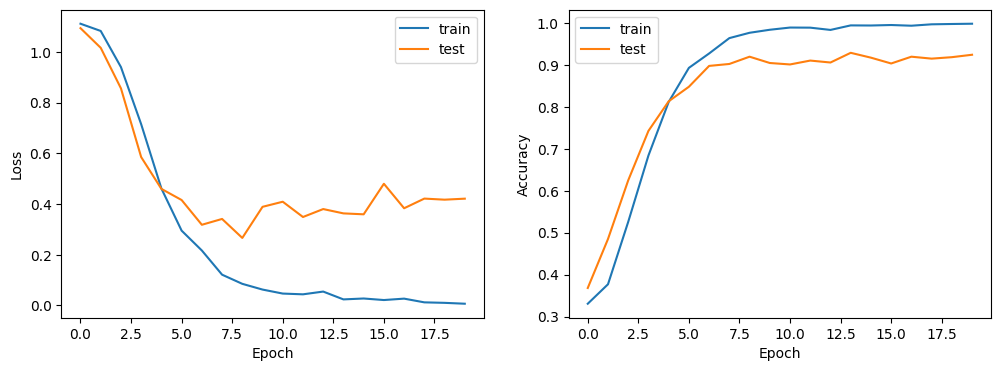

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

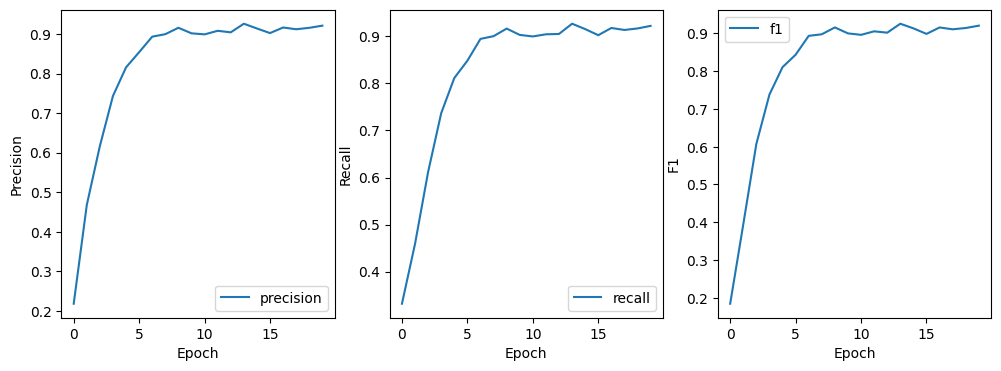

In [62]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(test_precisions, label='precision')
plt.xlabel('Epoch')
plt.ylabel('Precision') 
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_recalls, label='recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_f1s, label='f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.show()

In [66]:
best_model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, num_classes).to(device)
checkpoint = torch.load('best_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98       320
     neutral       0.94      0.87      0.90       295
    positive       0.88      0.92      0.90       249

    accuracy                           0.93       864
   macro avg       0.93      0.93      0.93       864
weighted avg       0.93      0.93      0.93       864



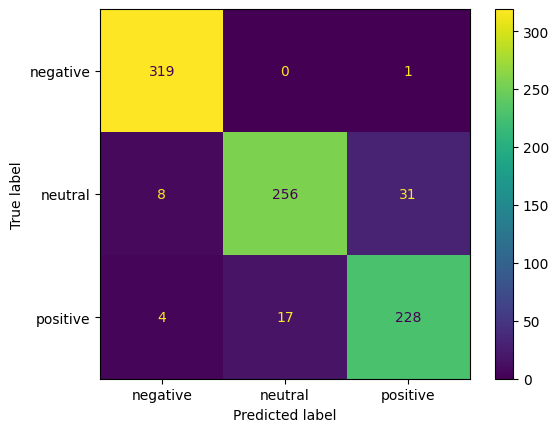

In [67]:
best_model.eval()
y_true = []
y_preds = []

with torch.inference_mode():
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = best_model(x)
        _, predicted = torch.max(y_pred.data, 1)
        y_true += y.tolist()
        y_preds += predicted.tolist()
    
print(classification_report(y_true, y_preds, target_names=['negative', 'neutral', 'positive']))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_preds), display_labels=['negative', 'neutral', 'positive']).plot()

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2559
     neutral       1.00      1.00      1.00      2584
    positive       1.00      0.99      1.00      2630

    accuracy                           1.00      7773
   macro avg       1.00      1.00      1.00      7773
weighted avg       1.00      1.00      1.00      7773



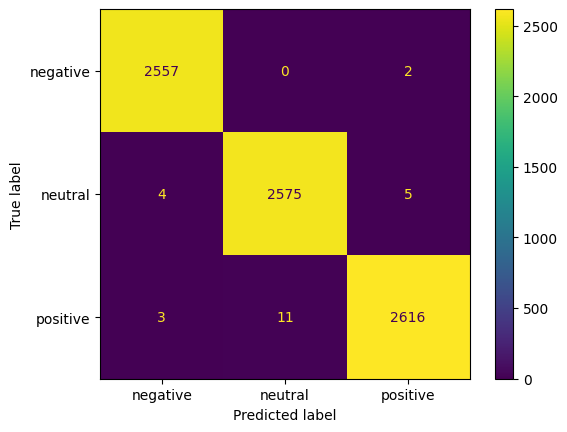

In [68]:
best_model.eval()
y_true = []
y_preds = []

with torch.inference_mode():
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y_pred = best_model(x)
        _, predicted = torch.max(y_pred.data, 1)
        y_true += y.tolist()
        y_preds += predicted.tolist()
        
print(classification_report(y_true, y_preds, target_names=['negative', 'neutral', 'positive']))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_preds), display_labels=['negative', 'neutral', 'positive']).plot()


In [65]:
torch.save(model.state_dict(), 'sentiment.pth')